### started 11/07/22
#### CNN
##### translation invariance - NN should respond to the same pattern, no matter where it is located
##### yearly layers conscentrated on local regions 

In [ ]:
# 6.2 Convolutions for Images
from d2l import mxnet as d2l
from mxnet import autograd, np, npx
from mxnet.gluon import nn
npx.set_np()

In [ ]:
def corr2d(X, K):
    """Compute 2D cross-correlation.
    K - kernel
    X - matrix of weights 
    (Nh - Kh + 1) x (Nw - Kw + 1) - > output size of convolutional operation 
    """
    h, w = K.shape
    Y = np.zeros((X.shape[0] - h + 1, X.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i, j] = d2l.reduce_sum((X[i: i + h, j: j + w] * K))
    return Y
X = np.array([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = np.array([[0.0, 1.0], [2.0, 3.0]]) 
corr2d(X, K)

In [ ]:
class conv2d(nn.Block): # create conv layer
    def __init__(self, kernel, **kwargs):
        super().__init__(**kwargs)
        self.ww = self.params.get('ww', shape=kernel)
        self.bb = self.params.get('bb', shape=(1,))
        
    def forward(self, X):
        return corr2d(X, self.ww.data()) + self.bb.data()
        
conv2d = conv2d((1, 2))
conv2d.initialize()
conv2d(X)

In [ ]:
# edge detector
num = np.ones((3,3))
num[:, 2:3] = 0
kernel = np.array([[1,-1]])
corr2d(num, kernel)

In [ ]:
# learning a kernel
conv_ = nn.Conv2D(1, kernel_size=(1, 2), use_bias=False)
conv_.initialize()

X = np.ones((6, 8))
X[:, 2:6] = 0 # add noise
K = np.array([[1.0, -1.0]]) # kernel to learn edge
Y = corr2d(X, K)

X = X.reshape(1, 1, 6, 8) # bathch size 1, channel 1, height 6, width 8
Y = Y.reshape(1, 1, 6, 7) # batch size 1, channel 1, height 6, width 7

In [ ]:
for epoch in range(10):
    with autograd.record():
        Y_pred = conv_(X)
        l = (Y_pred - Y) ** 2
    l.backward()
    conv_.weight.data()[:] -= conv_.weight.grad() * 3e-2
    if (epoch + 1) % 2 == 0:
        print('epoch %d, loss %.3f' % (epoch + 1, l.sum()))
conv_.weight.data()

In [ ]:
# 1. Construct an image X with diagonal edges.
X1 = np.ones((5, 5))
for i in range(5):
    X1[i, i] = 0
# 1. What happens if you apply the kernel K in this section to it?
kernel1 = np.array([[1,-1], [-1,1]])
corr2d(X1, kernel1) 

In [ ]:
# Padding 
# (nh - kh + ph + 1) x (nw - kw + pw + 1)
## using odd kernels and padding

# Stride
# (nh − kh + ph + sh)/ sh × (nw − kw + pw + sw)/ sw
conv2d = nn.Conv2D(1, kernel_size=(3, 5), padding=(0, 1), strides=(3, 4))
conv2d

In [ ]:
# Multiple input / output chanels
# chanel dimention for color images is 3

# the shape of convolutional kernel c0 × ci × kh × kw (c0 input, ci output number of channels)

In [ ]:
# 1 × 1 Convolutional Layer implementation 

def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    Y = np.dot(K, X) # Matrix multiplication in the fully-connected layer
    return Y.reshape((c_o, h, w))

def corr2d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and `K`. Then, add them together
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))

def corr2d_multi_in_out(X, K):
    # Iterate through the 0th dimension of `K`, and each time, perform
    # cross-correlation operations with input `X`. All of the results are stacked together
    return np.stack([corr2d_multi_in(X, k) for k in K], 0)

X = np.random.normal(0, 1, (3, 3, 3))
K = np.random.normal(0, 1, (2, 3, 1, 1))

Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)

assert d2l.reduce_sum(np.abs(Y1-Y2)) < 1e-6 # check if the results are the same
# -> it is the same cross-correlation function but with more dimentions (3, 3, 3)

In [ ]:
# Pooling
# pooling layers, which serve the dual purposes of mitigating the sensitivity
# of convolutional layers to location and of spatially downsampling representations.

In [ ]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

X = d2l.reshape(np.arange(16, dtype=np.float32), (1, 1, 4, 4))
X.shape

In [ ]:
# One of the major benefits of a pooling layer is to alleviate the excessive sensitivity of the convolutional layer to location

In [ ]:
# In a CNN, convolutional layers are typically arranged so that they gradually decrease the
# spatial resolution of the representations, while increasing the number of channels.

### cross correlation multiple input / output

In [1]:
from d2l import mxnet as d2l
from mxnet import np, npx
npx.set_np()

X = np.array([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
                [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = np.array([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

print(X.shape, K.shape)

(2, 3, 3) (2, 2, 2)


In [8]:
def corr_sum(X,K):
    return sum(d2l.corr2d(x, k) for x, k in zip(X, K))
print(corr_sum(X,K).shape)
corr_sum(X,K)

(2, 2)


array([[ 56.,  72.],
       [104., 120.]])

In [25]:
# In cross-correlation operations, the result on each output channel is calculated from the convolution kernel
# corresponding to that output channel and takes input from all channels in the input tensor.
def cross_corr_mult_channel(X, K):
    return np.stack([corr_sum(X, k) for k in K], 0)
print(X.shape)

K_multi = np.stack((K, K+1, K+2), 0)
print(K_multi.shape)

res = cross_corr_mult_channel(X, K_multi)
print(res.shape)
res

(2, 3, 3)
(3, 2, 2, 2)
(3, 2, 2)


array([[[ 56.,  72.],
        [104., 120.]],

       [[ 76., 100.],
        [148., 172.]],

       [[ 96., 128.],
        [192., 224.]]])

### LeCun NET #

In [ ]:
# each layer is (batch size, number of channel, height, width)
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

net = nn.Sequential()
net.add(
    nn.Conv2D(channels=6, kernel_size=(5, 5), padding=(2, 2), activation='relu'),
    nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    nn.Conv2D(channels=16, kernel_size=(5 ,5), activation='relu'),
    nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    nn.Dense(120, activation='sigmoid'),
    nn.Dense(84, activation='sigmoid'),
    nn.Dense(10)
)
X = np.random.uniform(size=(1, 1, 28, 28))
net.initialize()
for layer in net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

In [26]:
# load data
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    if not device: # Query the first device where the first parameter is on
        device = list(net.collect_params().values())[0].list_ctx()[0]
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        X, y = X.as_in_ctx(device), y.as_in_ctx(device)
        metric.add(d2l.accuracy(net(X), y), y.size)
    return metric[0]/metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    net.initialize(force_reinit=True, ctx=device, init=init.Xavier())
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            # Here is the major difference compared with `d2l.train_epoch_ch3`
            X, y = X.as_in_ctx(device), y.as_in_ctx(device)
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y)
            l.backward()
            trainer.step(X.shape[0])
            metric.add(l.sum(), d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '  f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec ' f'on {str(device)}')
    return net

dsmd = train_ch6(net, train_iter, test_iter, num_epochs=10, lr=0.9)
# AVG pooling loss 0.521, train acc 0.797, test acc 0.762
# MaxPool2D 0.84
# adjust kernel size, Relu, new Dense layer, MaxPool - > 0.1
# Relu only for CL, MaxPool - > 0.889

AttributeError: 'DataLoader' object has no attribute 'shape'

In [ ]:
params = dsmd.collect_params()
for i in params:
    print(i, params[i].data().shape)
    d2l.show_images(params[i].data().reshape(6, 5, 5), 2, 4)
    break
# save model
net.save_parameters("net.params")

#### solve task 

In [1]:
from d2l import mxnet as d2l
from mxnet import autograd, gluon, init, np, npx
from mxnet.gluon import nn
npx.set_np()

new_net = nn.Sequential()
new_net.add(
    nn.Conv2D(channels=6, kernel_size=(5, 5), padding=(2, 2), activation='relu'),
    nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    nn.Conv2D(channels=16, kernel_size=(5 ,5), activation='relu'),
    nn.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    nn.Dense(128, activation='sigmoid'),
    nn.Dense(64, activation='sigmoid'),
    nn.Dense(10)
)
X = np.random.uniform(size=(1, 1, 28, 28))
new_net.initialize()
for layer in new_net:
    X = layer(X)
    print(layer.name, 'output shape:\t', X.shape)

new_net.load_parameters("net.params")


conv0 output shape:	 (1, 6, 28, 28)
pool0 output shape:	 (1, 6, 14, 14)
conv1 output shape:	 (1, 16, 10, 10)
pool1 output shape:	 (1, 16, 5, 5)
dense0 output shape:	 (1, 128)
dense1 output shape:	 (1, 64)
dense2 output shape:	 (1, 10)


(256, 1, 28, 28) (256,)
215.0
(256, 10)
(1, 28, 28)


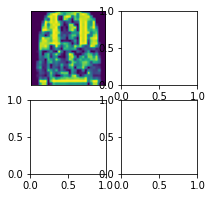

In [3]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=256)
for test, target in test_iter:
    print(test.shape, target.shape)
    print(d2l.accuracy(new_net(test), target))
    print(new_net(test).shape)
    d2l.show_images(test[3], 2, 2)
    print(test[3].shape)
    break

(6, 1, 5, 5)

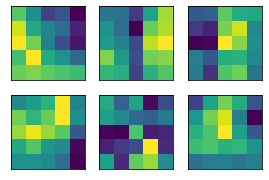

In [3]:
d2l.show_images(new_net[0].weight.data().reshape(6, 5 ,5),2,3)
new_net[0].weight.data().shape
# d2l.predict_ch3(net, test_iter)

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

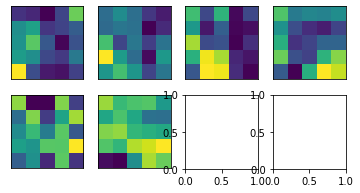

In [4]:
d2l.show_images(new_net[2].weight.data()[0], 2, 4)

### AlexNET
AlexNet controls the model complexity of the fully-connected layer by dropout (Section 4.6), while
LeNet only uses weight decay
##### histograms of oriented gradient - dominating before learning image representation